In [7]:
import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'cell-images-for-detecting-malaria:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F87153%2F200743%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240501%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240501T235047Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D9518144b610fadbefc3000f4825b195624b04cfad8301e765c4180f178059f56dd0f3a5b31c369bad3e7de230cf034379ce70db4b4fc99baab2b5f7bfee2ecf4bfe8b6db096b3fa17d2cf981303df380e4690b9f0e28484e527e73a08e68f9387c526790418fd42f7a9495712fc7a980b46186deafabf7367a8ee0ec4e265d522361928ddc08cc40493957faa3a335c03d28c971441726dc603489fd1747f7e656967980881f5767e9be0cc5913357e587b3bcfc56c3b67152abc43e8622c5ecd6f1d99de1d0f7e11fefd97cef169752aa5563906020a16b61f76f9b4efda421401a03d995122c92abfe321619ae8b812ef4d0c04f2e45aa8c2a09a52cf76fa7'

KAGGLE_INPUT_PATH = '/kaggle/input'

# Remove any existing input directory and create a new one
shutil.rmtree(KAGGLE_INPUT_PATH, ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, exist_ok=True)

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)

    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
                with ZipFile(tfile) as zfile:
                    zfile.extractall(destination_path)
            else:
                with tarfile.open(tfile.name) as tarfile:
                    tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 708172590 bytes downloaded
Downloaded and uncompressed: cell-images-for-detecting-malaria
Data source import complete.


> Use the GPU if available for computations.

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

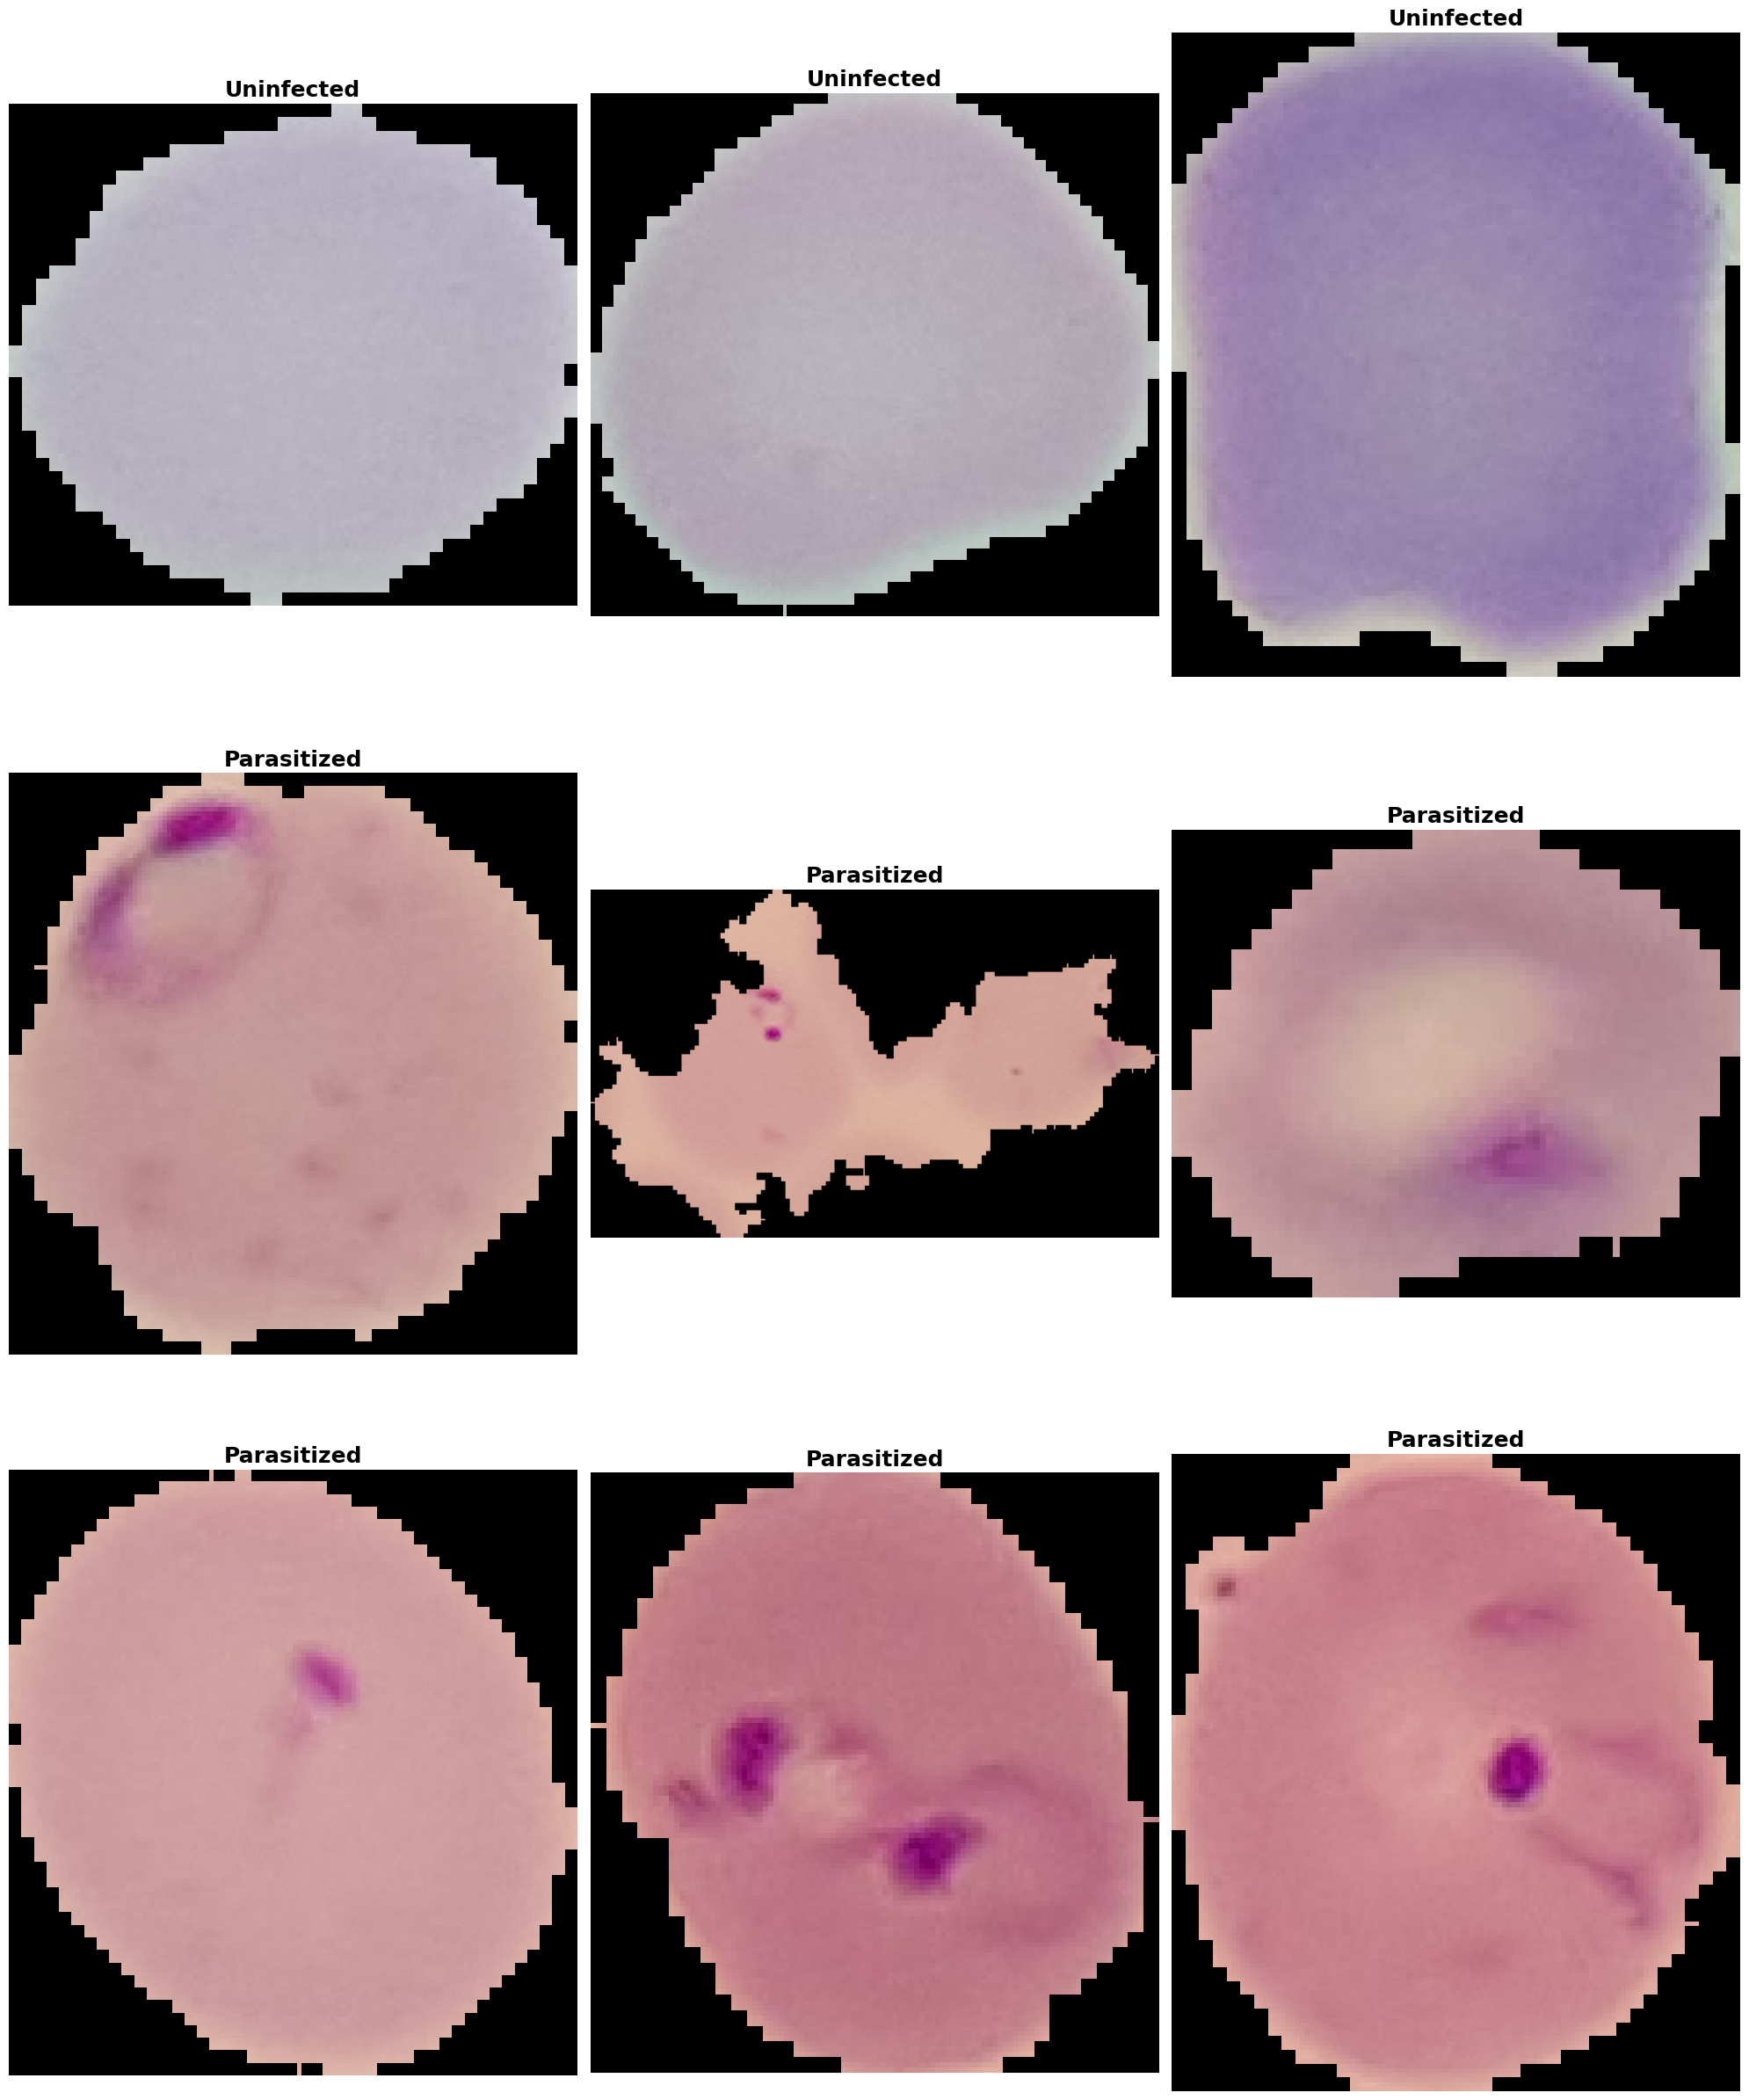

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

def generate_dataset(path):
    data = {'imgpath': [], 'labels': []}

    folders = os.listdir(path)

    for folder in folders:
        folderpath = os.path.join(path, folder)
        files = os.listdir(folderpath)

        for file in files:
            filepath = os.path.join(folderpath, file)

            data['imgpath'].append(filepath)
            data['labels'].append(folder)

    return pd.DataFrame(data)

path = '/kaggle/input/cell-images-for-detecting-malaria/cell_images'

dataset = generate_dataset(path)

# Drop the 'cell_images' label if it exists
value_to_drop = 'cell_images'
dataset = dataset[dataset['labels'] != value_to_drop]

# Plot a grid of sample images
def plot_image_grid(dataset, num_rows, num_cols):
    plt.figure(figsize=(20, 25))

    shuffled_dataset = dataset.sample(frac=1).reset_index(drop=True)

    num_samples = min(len(shuffled_dataset), num_rows * num_cols)

    for i in range(num_samples):
        plt.subplot(num_rows, num_cols, i + 1)
        row = shuffled_dataset.iloc[i]
        image_path = row['imgpath']
        image = Image.open(image_path)
        plt.imshow(image)
        plt.title(row["labels"], fontsize=18, fontweight='bold')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Display a grid of sample images
plot_image_grid(dataset, 3, 3)


In [20]:
import os
import cv2
import pandas as pd
import matplotlib.pyplot as plt

# Define the path to the data directory
data_dir = '/kaggle/input/cell-images-for-detecting-malaria/cell_images'

# Function to generate the dataset
def generate_dataset(path):
    data = {'imgpath': [], 'labels': []}

    folders = os.listdir(path)

    for folder in folders:
        folderpath = os.path.join(path, folder)
        if os.path.isdir(folderpath):
            files = os.listdir(folderpath)
            for file in files:
                filepath = os.path.join(folderpath, file)
                if os.path.isfile(filepath):
                    data['imgpath'].append(filepath)
                    data['labels'].append(folder)

    return pd.DataFrame(data)

# Generate the dataset DataFrame
dataset = generate_dataset(data_dir)

# Define the function to plot and save samples
def plot_and_save_samples(df, num_pairs=4, save_dir='samples'):
    os.makedirs(save_dir, exist_ok=True)
    classes = df['labels'].unique()

    for i in range(num_pairs):
        plt.figure(figsize=(10, 5))

        sample_infected = df[df['labels'] == 'Parasitized'].sample(1)
        img_infected = cv2.imread(sample_infected.iloc[0]['imgpath'])
        img_infected = cv2.cvtColor(img_infected, cv2.COLOR_BGR2RGB)
        plt.subplot(1, 2, 1)
        plt.imshow(img_infected)
        plt.title('Infected')
        plt.axis('off')

        sample_uninfected = df[df['labels'] == 'Uninfected'].sample(1)
        img_uninfected = cv2.imread(sample_uninfected.iloc[0]['imgpath'])
        img_uninfected = cv2.cvtColor(img_uninfected, cv2.COLOR_BGR2RGB)
        plt.subplot(1, 2, 2)
        plt.imshow(img_uninfected)
        plt.title('Uninfected')
        plt.axis('off')

        plt.savefig(os.path.join(save_dir, f'sample_{i+1}.png'))
        plt.close()

# Plot four pairs of infected and uninfected cell images and save them
plot_and_save_samples(dataset, num_pairs=4, save_dir='sample_images')


### Data Augmentation

* > Using Pytorch transformation function to augment a dataset. I tried different transformations but find these helpful.
* > All the images are resized to 120 * 120 as an input to custom CNN class.
* > Applying different transformations like RandomHorizontalFlip( ), RandomRotation( ) etc. There is a 50/50 chance whether it would change the image or not.
* > Converting images into Pytorch tensors.
* > Also normalizing them with mean [0.5, 0.5., 0.5] and standard deviation [0.5, 0.5, 0.5]. All tensors are in range of [-1, 1].
    > It won't increase size of the dataset as transformation performs one by one on images.

Length of the dataset: 27558


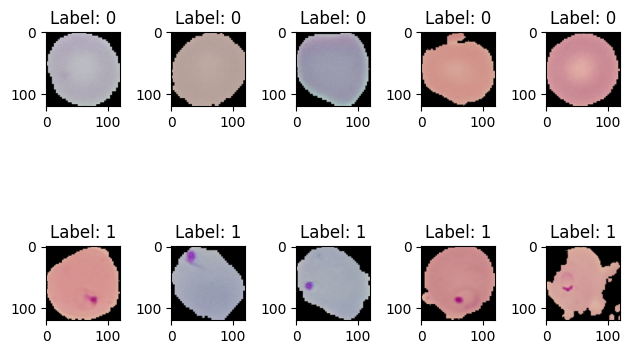

Class counts:
Uninfected: 13779
Parasitized: 13779
cell_images: 0


In [65]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image

# Define the MalariaDataset class
class MalariaDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.transform = transform
        self.images = []
        self.labels = []
        self.classes = os.listdir(image_dir)

        # Iterate over classes (subdirectories)
        for i, cls in enumerate(self.classes):
            class_dir = os.path.join(image_dir, cls)
            # Iterate over images in each class directory
            for img_name in os.listdir(class_dir):
                img_path = os.path.join(class_dir, img_name)
                if os.path.isfile(img_path) and img_name.endswith(('.png', '.jpg', '.jpeg')):  # Check if file is an image
                    self.images.append(img_path)
                    self.labels.append(i)  # Assign label based on class index

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        label = self.labels[idx]

        # Read the image
        try:
            image = cv2.imread(img_path)
            if image is None:  # Check if image could not be read
                raise Exception("Image could not be read")

            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB
            image = Image.fromarray(image)  # Convert to PIL Image
        except Exception as e:
            print(f"Error reading image at path: {img_path}")
            print(f"Error message: {e}")
            # Return a placeholder image if image cannot be read
            image = Image.new('RGB', (120, 120), (255, 255, 255))  # White image
            label = -1  # Assign a dummy label

        # Apply transformations
        if self.transform:
            image = self.transform(image)

        return image, label

# Define transformations
test_transforms = transforms.Compose([
    transforms.Resize((120, 120)),
    transforms.ToTensor(),
])

# Define the image directory
image_dir = "../input/cell-images-for-detecting-malaria/cell_images/"

# Create an instance of the dataset
dataset = MalariaDataset(image_dir=image_dir, transform=test_transforms)

# Test length of the dataset
print("Length of the dataset:", len(dataset))

# Test the __getitem__ method
for i in range(5):  # Test with 5 samples
    # Select images from different classes
    idx_label_0 = dataset.labels.index(0)
    idx_label_1 = dataset.labels.index(1)

    image_label_0, label_0 = dataset[idx_label_0 + i]  # Images with label 0
    image_label_1, label_1 = dataset[idx_label_1 + i]  # Images with label 1

    # Convert tensor to numpy array and transpose dimensions for plotting
    image_label_0 = image_label_0.numpy().transpose((1, 2, 0))
    image_label_1 = image_label_1.numpy().transpose((1, 2, 0))

    # Plot the images
    plt.subplot(2, 5, i + 1)
    plt.imshow(image_label_0)
    plt.title(f"Label: {label_0}")

    plt.subplot(2, 5, i + 6)
    plt.imshow(image_label_1)
    plt.title(f"Label: {label_1}")

plt.tight_layout()
plt.show()

# Test integration over classes
class_counts = {cls: 0 for cls in dataset.classes}
for _, label in dataset:
    if label != -1:  # Skip dummy labels
        class_counts[dataset.classes[label]] += 1

print("Class counts:")
for cls, count in class_counts.items():
    print(f"{cls}: {count}")


In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms

# Define your dataset class
class MalariaDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.transform = transform
        self.dataset = datasets.ImageFolder(self.image_dir, transform=self.transform)

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        return self.dataset[idx]

# Define transformations for your dataset
train_transforms = transforms.Compose([
    transforms.Resize((120, 120)),
    transforms.ColorJitter(0.05),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(20),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

# Define your image directory
image_dir = "../input/cell_images/cell_images/"

# Create dataset instance
train_set = MalariaDataset(image_dir=image_dir, transform=train_transforms)

# Create DataLoader instance
batch_size = 104
shuffle = True
num_workers = 2
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers)

# Iterate through the dataloader
for batch in train_loader:
    images, labels = batch

    # Move images and labels to the device (GPU if available)
    images, labels = images.to(device), labels.to(device)

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


In [ ]:
"""
train_transforms = transforms.Compose([transforms.Resize((120, 120)),
                                       transforms.ColorJitter(0.05),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.RandomVerticalFlip(),
                                       transforms.RandomRotation(20),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
                                     ])
"""

'\ntrain_transforms = transforms.Compose([transforms.Resize((120, 120)),\n                                       transforms.ColorJitter(0.05),\n                                       transforms.RandomHorizontalFlip(),\n                                       transforms.RandomVerticalFlip(),\n                                       transforms.RandomRotation(20),\n                                       transforms.ToTensor(), \n                                       transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])\n                                     ])\n'

> Loading a images using generic dataloader ImageFolder.

In [ ]:
#image_dir = "../input/cell_images/cell_images/"
#train_set = datasets.ImageFolder(image_dir, transform=train_transforms)

In [ ]:
classes=['infected','uninfected']

> Visualizing some Images...

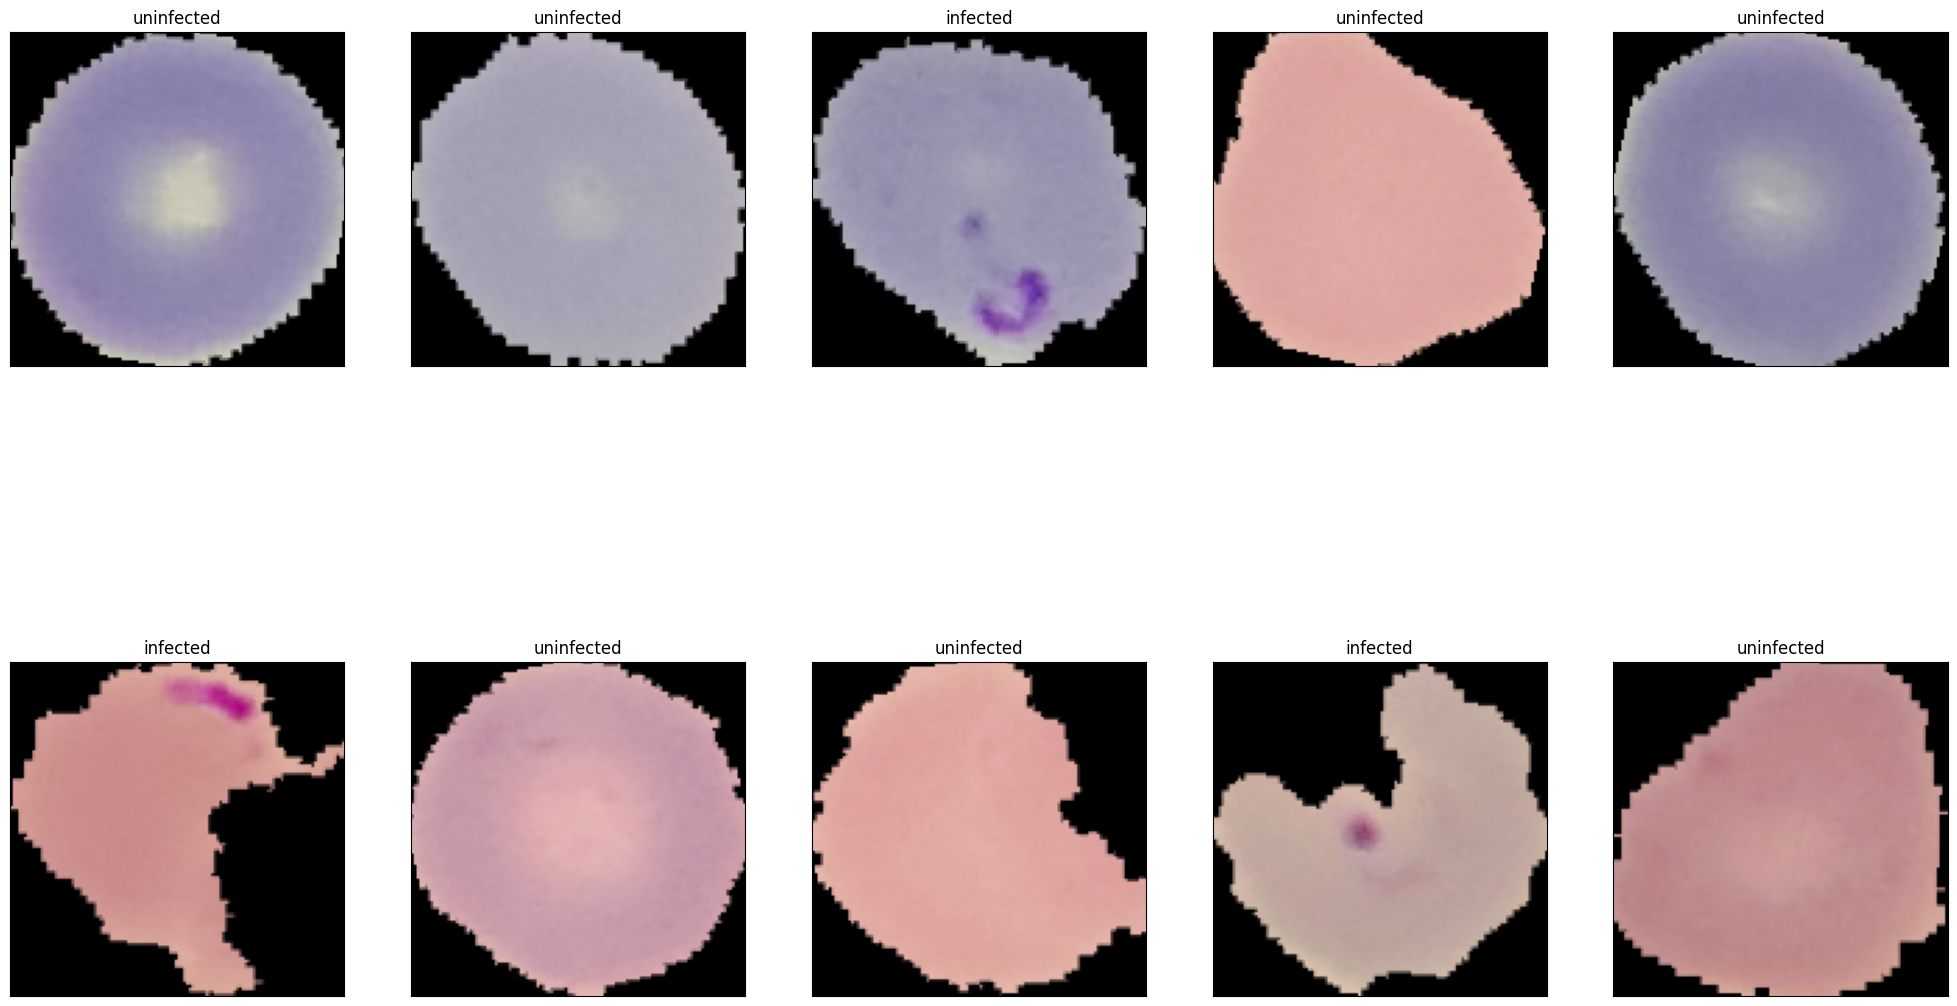

In [ ]:
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

images, labels = next(iter(train_loader))

fig = plt.figure(figsize=(25, 15))

for i in range(10):
    ax = fig.add_subplot(2, 5, i+1, xticks=[], yticks=[], title=classes[labels[i]])
    imshow(images[i])
plt.show()

### CNN class
* Creating a CNN class as MosquitoNet.
* It has following layers:
    * 3 Convolutional layers with MaxPooling (Stride 2)
    * All 3 convulations are "Same Convolution with some zero-padding"
    * 3 FullyConnected Layers
* BatchNormalization is used after convulations
* ReLU is used as a activation function
* Dropout is used with p = 0.5

* Images are changed from input to output layers in following way:
    * In Layer 1 : Input: 120 \* 120 \* 3, Output: 60 \* 60 \* 16
    * In Layer 2 : Input: 60 \* 60 \* 16, Output: 30 \* 30 \* 32
    * In Layer 3 : Input: 30 \* 30 \* 32, Output: 15 \* 15 \* 64
    * In FC1 : Input: 14440, Output: 512
    * In FC2 : Input: 512, Output: 128
    * In FC3 : Input: 128, Output: 2

In [66]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MosquitoNet(nn.Module):

    def __init__(self):
        super(MosquitoNet, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.layer3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.fc1 = nn.Linear(64*15*15, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, 2)
        self.drop = nn.Dropout2d(0.2)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.view(out.size(0), -1)    # flatten out a input for Dense Layer
        out = self.fc1(out)
        out = F.relu(out)
        out = self.drop(out)
        out = self.fc2(out)
        out = F.relu(out)
        out = self.drop(out)
        out = self.fc3(out)

        return out

# Specify device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Instantiate the model
model = MosquitoNet()
model.to(device)  # Move the model to the appropriate device (GPU or CPU)

MosquitoNet(
  (layer1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=14400, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=12

> Making a model and defining error and optimizing algorithm.

In [44]:
model = MosquitoNet()
model.to(device)
error = nn.CrossEntropyLoss()
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
print(model)

MosquitoNet(
  (layer1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=14400, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=12

### Training a Model

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
from dataset import MalariaDataset
from mymodel import MosquitoNet

# Define device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Define hyperparameters
num_epochs = 10
batch_size = 100
learning_rate = 0.001

# Define data transformations
train_transforms = transforms.Compose([
    transforms.Resize((120, 120)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(20),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

# Define dataset and dataloader
image_dir = "../input/cell-images-for-detecting-malaria/cell_images/"
train_dataset = MalariaDataset(image_dir=image_dir, transform=train_transforms)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Instantiate model
model = MosquitoNet().to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}:")
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    for i, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Update statistics
        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        total_predictions += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_dataset)
    epoch_accuracy = correct_predictions / total_predictions * 100

    print(f"   Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%")

# Save the trained model
torch.save(model.state_dict(), "model.pth")


In [ ]:
"""
num_epochs = 10
batch_size = 100

for epoch in range(num_epochs):
    train_loss = 0.
    model.train()    # explictily stating the training

    for i, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)
        train = images.view(-1, 3, 120, 120)
        outputs = model(train)

        optimizer.zero_grad()
        loss = error(outputs, labels)
        loss.backward()    #back-propagation
        optimizer.step()

        train_loss += loss.item() * batch_size

    print("Epoch: {}, Loss: {:.4f}".format(epoch + 1, train_loss / len(train_loader.dataset)))
"""
num_epochs = 10
batch_size = 100

for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}:")

    train_loss = 0.
    correct_predictions = 0
    total_predictions = 0
    model.train()    # explicitly stating the training
    print("   Model set to training mode.")

    for i, (images, labels) in enumerate(train_loader):
        print(f"   Batch {i + 1}:")

        images, labels = images.to(device), labels.to(device)
        print("      Images and labels moved to device.")

        train = images.view(-1, 3, 120, 120)
        print("      Images reshaped.")

        outputs = model(train)
        print("      Forward pass completed.")

        optimizer.zero_grad()
        print("      Gradient buffers zeroed.")

        loss = error(outputs, labels)
        print(f"      Loss calculated: {loss.item()}")

        loss.backward()    # back-propagation
        print("      Backward pass completed.")

        optimizer.step()
        print("      Optimization step completed.")

        train_loss += loss.item() * batch_size

        # Calculate accuracy
        _, predicted = torch.max(outputs, 1)
        total_predictions += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()

    # Calculate accuracy and loss
    epoch_loss = train_loss / len(train_loader.dataset)
    epoch_accuracy = correct_predictions / total_predictions * 100

    print(f"   Epoch {epoch + 1} completed: Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%")

Streaming output truncated to the last 5000 lines.
      Optimization step completed.
   Batch 13:
      Images and labels moved to device.
      Images reshaped.
      Forward pass completed.
      Gradient buffers zeroed.
      Loss calculated: 0.12150446325540543
      Backward pass completed.
      Optimization step completed.
   Batch 14:
      Images and labels moved to device.
      Images reshaped.
      Forward pass completed.
      Gradient buffers zeroed.
      Loss calculated: 0.18306668102741241
      Backward pass completed.
      Optimization step completed.
   Batch 15:
      Images and labels moved to device.
      Images reshaped.
      Forward pass completed.
      Gradient buffers zeroed.
      Loss calculated: 0.032285284250974655
      Backward pass completed.
      Optimization step completed.
   Batch 16:
      Images and labels moved to device.
      Images reshaped.
      Forward pass completed.
      Gradient buffers zeroed.
      Loss calculated: 0.115260906

### Testing a model

In [ ]:
correct = 0
total = 0
class_total = [0 for _ in range(2)]
class_correct = [0 for _ in range(2)]
batch_size = 58
# Lists used in Confusion Matrix
actual = []
predict = []

model.eval()    # explicitly stating the testing
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to (device)

        actual.append(labels.data.tolist())
        test = images.view(-1, 3, 120, 120)
        outputs = model(test)
        predicted = torch.max(outputs, 1)[1]
        predict.append(predicted.data.tolist())
        total += len(labels)
        correct += (predicted == labels).sum().item()
        # Calculating classwise accuracy
        c = (predicted == labels).squeeze()
        for i in range(batch_size):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

print("Accuracy on the Test set: {:.2f}%".format(correct * 100 / total))
print()
for i in range(2):
    print("Accuracy of {} :  {:.2f}%   [{} / {}]".format(classes[i], class_correct[i] * 100 / class_total[i],
                                           class_correct[i], class_total[i]))

Accuracy on the Test set: 96.13%

Accuracy of infected :  94.93%   [2639 / 2780]
Accuracy of uninfected :  97.36%   [2658 / 2730]


> Calculating a Confusion Matrix

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
import itertools

#flatten out 2D list into 1D
actual = list(itertools.chain.from_iterable(actual))
predict = list(itertools.chain.from_iterable(predict))


In [ ]:
results = confusion_matrix(actual, predict)
print("Accuracy Score: ")
print("{:.4f}".format(accuracy_score(actual, predict)))
print()
print("Report: ")
print(classification_report(actual, predict))
print()
print("Confusion Matrix: ")
print(pd.DataFrame(results, columns=["Predicted No", "Predicted Yes"], index=["Actual No", "Actual Yes"]))

Accuracy Score: 
0.9613

Report: 
              precision    recall  f1-score   support

           0       0.97      0.95      0.96      2780
           1       0.95      0.97      0.96      2730

    accuracy                           0.96      5510
   macro avg       0.96      0.96      0.96      5510
weighted avg       0.96      0.96      0.96      5510


Confusion Matrix: 
            Predicted No  Predicted Yes
Actual No           2639            141
Actual Yes            72           2658


> Displaying it as a plot

<Axes: >

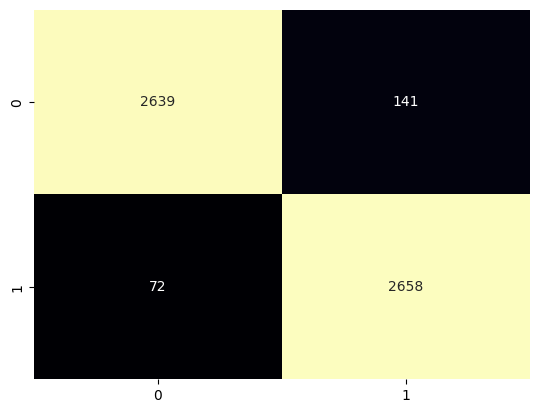

In [ ]:
import seaborn as sns

sns.heatmap(results, cmap="magma", annot=True, fmt="d", cbar=False)